## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

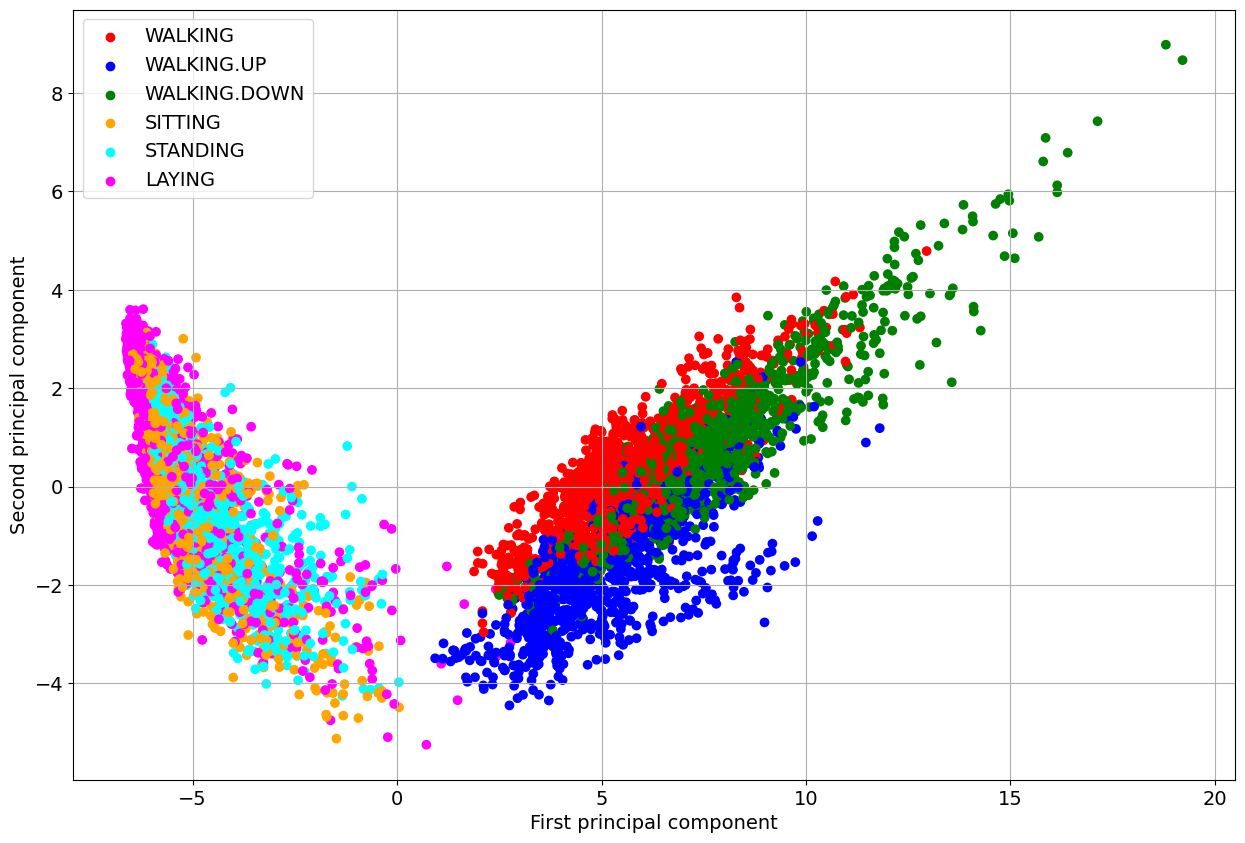

In [3]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [4]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# One-hot encoding
y_train_one_hot = torch.eye(n_classes)[torch.tensor(y_train).squeeze()]
y_test_one_hot = torch.eye(n_classes)[torch.tensor(y_test).squeeze()]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)
X_val = torch.tensor(X_val, dtype=torch.float32, requires_grad=True)
y_val = torch.tensor(y_val, dtype=torch.float32, requires_grad=True)
X_test = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(y_test_one_hot, dtype=torch.float32, requires_grad=True)


/tmp/ipykernel_63050/627769515.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)
/tmp/ipykernel_63050/627769515.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.float32, requires_grad=True)
/tmp/ipykernel_63050/627769515.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_one_hot, dtype=torch.float32, requires_grad=True)


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [7]:
class CustomConv1dModel(nn.Module):
    def __init__(self, n_channels, n_classes, dropout_prob=0.3):
        super(CustomConv1dModel, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels=n_channels, out_channels=18, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm1d(18),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_prob),
            
            nn.Conv1d(in_channels=18, out_channels=36, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm1d(36),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_prob),
            
            nn.Conv1d(in_channels=36, out_channels=72, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm1d(72),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_prob),
            
            nn.Conv1d(in_channels=72, out_channels=144, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm1d(144),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_prob),
            
            nn.Conv1d(in_channels=144, out_channels=288, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm1d(288),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_prob),
        )

        # Примерный расчет размерности
        self.fc = nn.Linear(288 * 4, n_classes)  # 2 - длина последовательности после пулинга

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
seq_len = n_steps
n_channels = 9
n_classes = 6
batch_size = 32

In [9]:
X_train_tensor = X_train.permute(0, 2, 1).clone().detach().requires_grad_(True).to(torch.float32)
y_train_tensor = y_train.clone().detach().requires_grad_(True).to(torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

X_val_tensor = X_val.permute(0, 2, 1).clone().detach().requires_grad_(True).to(torch.float32)
y_val_tensor = y_val.clone().detach().requires_grad_(True).to(torch.float32)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

X_test_tensor = X_test.permute(0, 2, 1).clone().detach().requires_grad_(True).to(torch.float32)
y_test_tensor = y_test.clone().detach().requires_grad_(True).to(torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [10]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, name='best_model', save=False):
    history = []
    acc_old, loss_old = 0, 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
    

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            total_train += labels.size(0)
            labels_indices = labels.argmax(dim=1)
            correct_train += (predicted == labels_indices).sum().item()


        scheduler.step()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train


        # Валидация
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                labels_indices = labels.argmax(dim=1)
                correct_val += (predicted == labels_indices).sum().item()
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        if save:
            if acc_old < val_accuracy and loss_old > val_loss:
                torch.save(model, name+'.pth')
                print('Save params')
                acc_old = val_accuracy
                loss_old = val_loss
        # Сохранение истории
        history.append((train_loss, train_accuracy, val_loss, val_accuracy))
       
        
        
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return history

In [12]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
learning_rate = 0.001
model = CustomConv1dModel(n_channels=n_channels, n_classes=n_classes).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.8)

In [14]:
test_hist = train_model(model, train_loader, val_loader, loss_func, optimizer, scheduler, epochs=20, name='har_best', save=True)

Save params
Epoch [1/20], Train Loss: 0.5564, Train Accuracy: 0.7631, Val Loss: 0.9328, Val Accuracy: 0.6411
Save params
Epoch [2/20], Train Loss: 0.2800, Train Accuracy: 0.8908, Val Loss: 0.3889, Val Accuracy: 0.8606
Epoch [3/20], Train Loss: 0.2161, Train Accuracy: 0.9150, Val Loss: 0.3675, Val Accuracy: 0.8545
Save params
Epoch [4/20], Train Loss: 0.2031, Train Accuracy: 0.9180, Val Loss: 0.2800, Val Accuracy: 0.8729
Epoch [5/20], Train Loss: 0.1757, Train Accuracy: 0.9262, Val Loss: 0.3349, Val Accuracy: 0.8661
Epoch [6/20], Train Loss: 0.1710, Train Accuracy: 0.9315, Val Loss: 0.3316, Val Accuracy: 0.8593
Save params
Epoch [7/20], Train Loss: 0.1485, Train Accuracy: 0.9390, Val Loss: 0.2126, Val Accuracy: 0.9191
Save params
Epoch [8/20], Train Loss: 0.1514, Train Accuracy: 0.9364, Val Loss: 0.2044, Val Accuracy: 0.9300
Epoch [9/20], Train Loss: 0.1436, Train Accuracy: 0.9408, Val Loss: 0.2339, Val Accuracy: 0.9130
Epoch [10/20], Train Loss: 0.1434, Train Accuracy: 0.9413, Val Loss

In [15]:
def predict_har(model, test_loader):
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = loss_func(outputs, labels)
            running_test_loss += test_loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            labels_indices = labels.argmax(dim=1)
            correct_test += (predicted == labels_indices).sum().item()

    test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test

    return test_accuracy, test_loss

In [18]:
def load_and_evaluate_model(file_path):
    model_loaded = torch.load(file_path, map_location=torch.device('cpu'))
    model_loaded.eval()
    print("Модель успешно загружена и переведена в режим оценки\n")
    return model_loaded

# Путь к файлу модели
model_file_path = 'har_best.pth'


# Загрузка и оценка модели
model_loaded = load_and_evaluate_model(model_file_path)

Модель успешно загружена и переведена в режим оценки



/tmp/ipykernel_63050/2133657132.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded = torch.load(file_path, map_location=torch.device('cpu'))


In [20]:
test_accuracy, test_loss = predict_har(model_loaded.to(device), test_loader)
print(f"На тестовых данных сверточная модель дает accuracy: {test_accuracy:.4f}")

На тестовых данных сверточная модель дает accuracy: 0.9321


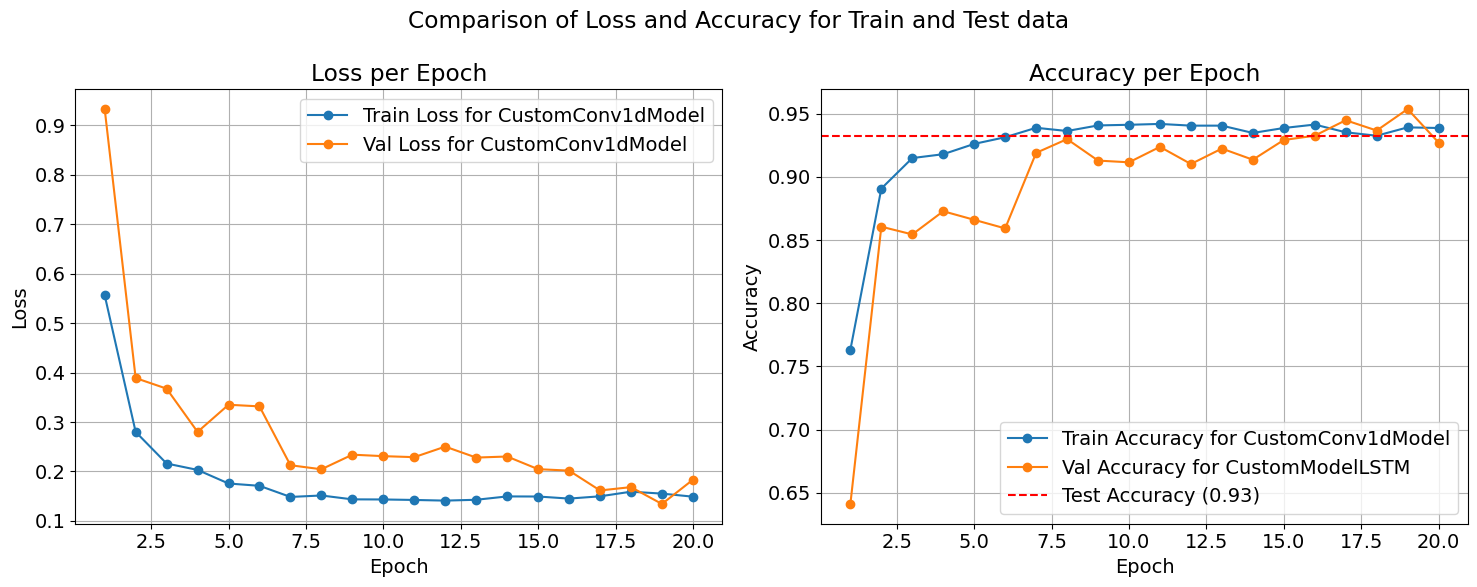

In [22]:
train_loss, train_acc, val_loss, val_acc = zip(*test_hist)

# График потерь
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', label=f'Train Loss for CustomConv1dModel')

plt.plot(range(1, len(val_loss) + 1), val_loss, marker='o', label=f'Val Loss for CustomConv1dModel')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, marker='o', label=f'Train Accuracy for CustomConv1dModel')

plt.plot(range(1, len(val_acc) + 1), val_acc, marker='o', label=f'Val Accuracy for CustomModelLSTM')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy ({test_accuracy:.2f})') # Горизонтальная линия
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of Loss and Accuracy for Train and Test data')
plt.tight_layout()

plt.show()

**Вывод**

В выбранном подходе используется набор сверточных слоев для классификации движения. Для того чтобы преодолеть переобучение, добавлены слои Dropout и BatchNormalization. Некоторое время пришлось потратить на эксперименты с архитектурой, увеличить количество сверточных слоев, чтобы получить необходимую точность. В процессе обучения веса лучшей модели сохранялись.

Графики loss и accuracy для тренировочных и валидационных данных приедены. Красным отмечено значение accuracy на тестовых данных для модели с лучшим лоссом и точностью за текущий процесс обучения. 

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [23]:
import pickle
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch

In [24]:
from pathlib import Path
from sklearn.model_selection import train_test_split

TRAIN_DIR = Path('./data/train')
TEST_DIR = Path('./data/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpeg')))  # Или *.png, в зависимости от формата изображений
test_files = sorted(list(TEST_DIR.rglob('*.jpeg')))

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.2, stratify=train_val_labels, random_state=42) # добавлено random_state для воспроизводимости

print(f"Количество тренировочных изображений: {len(train_files)}")
print(f"Количество валидационных изображений: {len(val_files)}")
print(f"Количество тестовых изображений: {len(test_files)}")


Количество тренировочных изображений: 5732
Количество валидационных изображений: 1434
Количество тестовых изображений: 1503


In [25]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [26]:
def load_sample(file):
    image = Image.open(file)
    image.load()
    return image

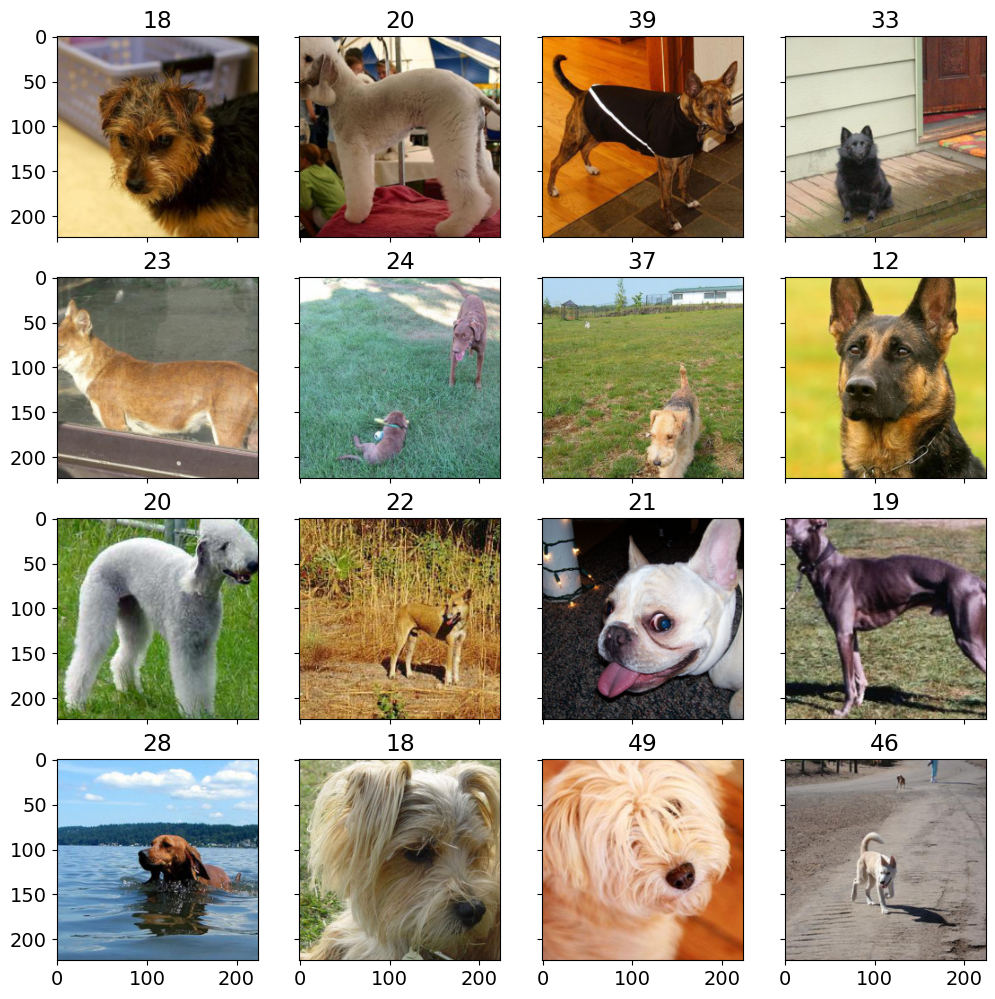

In [27]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val = val_files[random_characters]
    label = im_val.parent.name
    img = np.array(load_sample(im_val))
    img = np.array(img / 255, dtype='float32')
    transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(256),
                transforms.CenterCrop(224),

                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
    img = transform(img)
    imshow(img, title=label, plt_ax=fig_x)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import os
import random

# 1. Подготовка данных
class DogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.images = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.images.append((img_path, self.class_to_idx[class_name]))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


def train_val_split(dataset, val_size=0.2, seed=42):
    """
    Разбивает датасет на обучающую и валидационную выборки, сохраняя баланс классов.
    """
    random.seed(seed)
    class_indices = {}
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)
    
    train_indices = []
    val_indices = []
    for label, indices in class_indices.items():
        num_val = int(len(indices) * val_size)
        random.shuffle(indices)
        val_indices.extend(indices[:num_val])
        train_indices.extend(indices[num_val:])
    
    return torch.utils.data.Subset(dataset, train_indices), torch.utils.data.Subset(dataset, val_indices)


# Трансформации
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(hue=.1, saturation=.1), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = DogDataset(root_dir="data/train", transform=transform)
train_dataset, val_dataset = train_val_split(dataset)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [2]:
models.resnet50(pretrained=True)

/home/uolko/miniconda3/envs/opt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/uolko/miniconda3/envs/opt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset


def load_modified_resnet18():
    resnet18 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # Freeze layers
    for param in resnet18.parameters():
        param.requires_grad = False
    for param in resnet18.layer3.parameters():
        param.requires_grad = True
    for param in resnet18.layer4.parameters():
        param.requires_grad = True
    for param in resnet18.avgpool.parameters():
        param.requires_grad = True
    return resnet18

class CustomResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()
        self.resnet = load_modified_resnet18()
        self.extra_conv = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(512, 2048, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(0.5)
           
        )
       # Изменяем avgpool и fc слои
        self.resnet.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        # Проходим через дополнительные сверточные слои
        x = self.extra_conv(x)
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        

# Обучение и валидация
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    history = []
    acc_old, loss_old = 0, 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        scheduler.step()
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train


        # Валидация
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        if acc_old < val_accuracy and loss_old > val_loss:
            torch.save(model, 'best_model.pth')
            print('Save params')
            acc_old = val_accuracy
            loss_old = val_loss
        # Сохранение истории
        history.append((train_loss, train_accuracy, val_loss, val_accuracy))
       
        
        
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, LR: {optimizer.param_groups[0]['lr']}     ")
    
    return history


# 1. Параметры обучения
num_classes = 50
learning_rate = 1e-3

num_epochs = 100


# 3. Создание модели, оптимизатора и scheduler
model = CustomResNet18(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

optimizer = torch.optim.Adam([ 
    # {'params': model.resnet.fc.parameters(), 'lr': 0.005},
    # {'params': model.resnet.avgpool.parameters(), 'lr': 0.0007},
    {'params': model.resnet.layer3.parameters(), 'lr': 0.00005},
    {'params': model.resnet.layer4.parameters(), 'lr': 0.0001}], 
    lr=0.005
    )

# lambda1 = lambda epoch: 0.85 ** (epoch - 1)
# lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

# warmup_scheduler = LinearWarmupScheduler(
#     optimizer,
#     warmup_steps=warmup_steps,
#     start_lr=warmup_start_lr,
#     end_lr=learning_rate,
#     lr_scheduler = lr_scheduler
# )

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=0)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 25, 0.9)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer,
#     T_0=10,      # Первый перезапуск через 10 эпох
#     T_mult=2,    # Следующие перезапуски будут через 20, 40 эпох
#     eta_min=1e-6 # Минимальный learning rate
# )

In [20]:
import torchsummary
torchsummary.summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 25]           9,408
       BatchNorm2d-2           [-1, 64, 25, 25]             128
              ReLU-3           [-1, 64, 25, 25]               0
         MaxPool2d-4           [-1, 64, 13, 13]               0
            Conv2d-5           [-1, 64, 13, 13]           4,096
       BatchNorm2d-6           [-1, 64, 13, 13]             128
              ReLU-7           [-1, 64, 13, 13]               0
            Conv2d-8           [-1, 64, 13, 13]          36,864
       BatchNorm2d-9           [-1, 64, 13, 13]             128
             ReLU-10           [-1, 64, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]          16,384
      BatchNorm2d-12          [-1, 256, 13, 13]             512
           Conv2d-13          [-1, 256, 13, 13]          16,384
      BatchNorm2d-14          [-1, 256,

In [24]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.011764705882352941
    maximize: False
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0025
    lr: 0.0029411764705882353
    maximize: False
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.00025
    lr: 0.00029411764705882356
    maximize: False
    weight_decay: 0
)

In [ ]:
# num_epochs = 45

In [14]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler, num_epochs)

Save params
Epoch [1/100], Train Loss: 4.0177, Train Accuracy: 0.0241, Val Loss: 3.8927, Val Accuracy: 0.0383, LR: 4.9453690018345144e-05     
Save params
Epoch [2/100], Train Loss: 3.8514, Train Accuracy: 0.0450, Val Loss: 3.6264, Val Accuracy: 0.1723, LR: 4.783863644106502e-05     
Save params
Epoch [3/100], Train Loss: 3.5611, Train Accuracy: 0.1353, Val Loss: 3.2378, Val Accuracy: 0.3674, LR: 4.522542485937369e-05     
Save params
Epoch [4/100], Train Loss: 3.1992, Train Accuracy: 0.2844, Val Loss: 2.8759, Val Accuracy: 0.5447, LR: 4.172826515897146e-05     
Save params
Epoch [5/100], Train Loss: 2.8482, Train Accuracy: 0.4526, Val Loss: 2.4921, Val Accuracy: 0.6709, LR: 3.7500000000000003e-05     
Save params
Epoch [6/100], Train Loss: 2.5529, Train Accuracy: 0.5773, Val Loss: 2.2150, Val Accuracy: 0.7660, LR: 3.272542485937369e-05     
Save params
Epoch [7/100], Train Loss: 2.3183, Train Accuracy: 0.6704, Val Loss: 1.9924, Val Accuracy: 0.7993, LR: 2.7613211581691344e-05     
Sav

Для того чтобы обучить модель классифицировать собак пришлось делать fine-tune обученной модели resnet50.

**Сделано:**
* У этой модели поменял классификатор, так как родной классификатор модели классифицирует изображение на 1000 классов.
* Добавил блок из 3 сверточных слоев с бачнормом и дропаутом, для того чтобы избежать переобучения
* Так же для этого была применена аугментация на изображениях.
* Обучение с помощью scheduler.CosineAnnealingLR()
* Так же заморозил все слои кроме последних 2 блоков со свертками. Для них сделал меньший learning rate, чем глубже слой, тем меньше шаг обучения.

Было много экспериментов с разными модификациями архитектуры модели.

Лучший полученный результат accuracy: 0.8943 для обычной модели resnet50 с переписанным классификатором и размороженными 2 последними блоками сверток, по ним был сделан разный learning rate.

Модель, представленная в ноутбуке получила accuracy: 0.8936.

In [15]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure


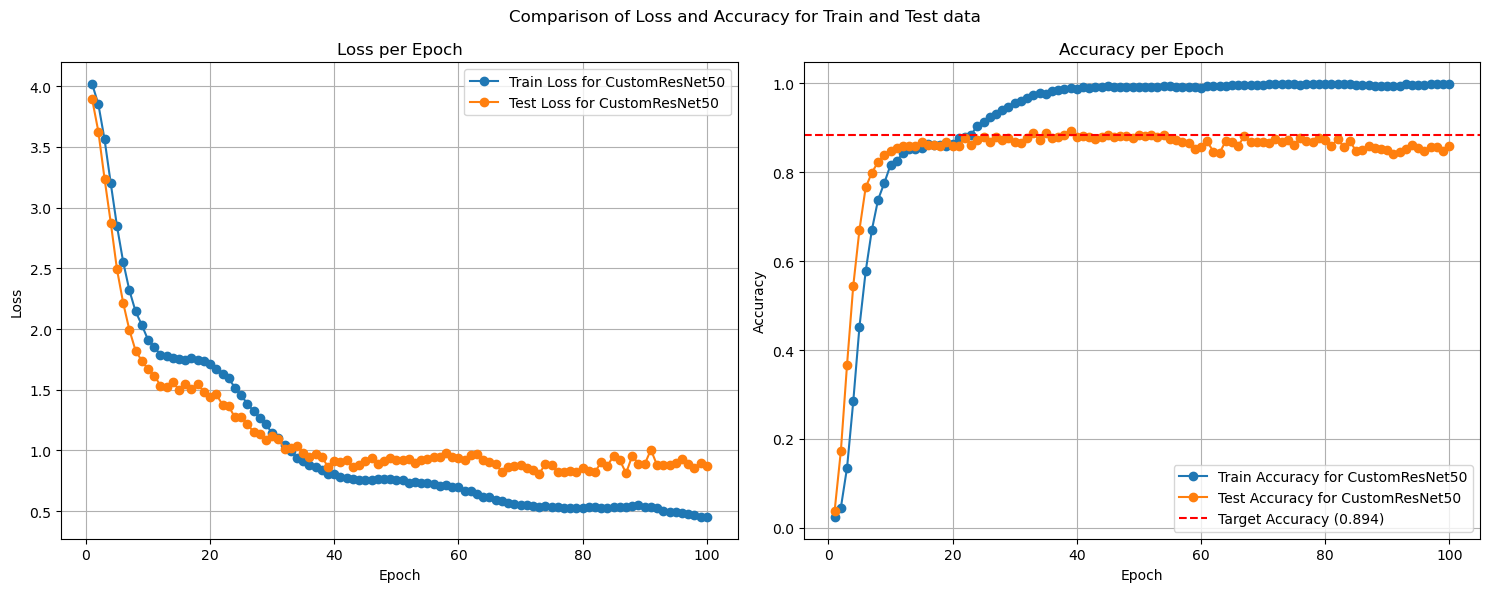

In [19]:
train_loss, train_acc, val_loss, val_acc = zip(*history)
name = '   '
# График потерь
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', label=f'Train Loss for CustomResNet50')
# plt.plot(range(1, len(test_losses_relu1) + 1), test_losses_relu1, marker='o', label='Test Loss w/o BatchNorm Adam')
plt.plot(range(1, len(val_loss) + 1), val_loss, marker='o', label=f'Test Loss for CustomResNet50')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, marker='o', label=f'Train Accuracy for CustomResNet50')
# plt.plot(range(1, len(test_accuracies_relu1) + 1), test_accuracies_relu1, marker='o',  label='Test Accuracy w/o BatchNorm Adam')
plt.plot(range(1, len(val_acc) + 1), val_acc, marker='o', label=f'Test Accuracy for CustomResNet50')
plt.axhline(y=0.885, color='r', linestyle='--', label='Target Accuracy (0.894)') # Горизонтальная линия
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of Loss and Accuracy for Train and Test data')
plt.tight_layout()

plt.show()